In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


2023-07-10 16:15:19.436792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:15:19.823851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-10 16:15:19.823863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-10 16:15:19.871900: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-10 16:15:20.765029: W tensorflow/stream_executor/platform/de

In [2]:
from PIL import Image
import numpy as np
import os

def convert_to_bw(img_path):
    img = Image.open(img_path).convert('L')
    return img

def resize_image(img, size=(128, 128)):
    return img.resize(size)

def convert_to_numpy_array(bw_img):
    img_array = np.array(bw_img)
    img_array = img_array / 255.0 # normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.reshape(img_array, (1, 128, 128))
    return img_array

def convert_images_to_arrays(root_dir):
    images = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.jpg'):
                img_path = os.path.join(dirpath, filename)
                bw_img = convert_to_bw(img_path)
                resized_img = resize_image(bw_img)
                img_array = convert_to_numpy_array(resized_img)
                images.append(img_array)
    return np.concatenate(images, axis=0)

root_dir = './archive'
image_arrays = convert_images_to_arrays(root_dir)
print(image_arrays[0][15:20])
print(image_arrays.shape) # prints (num_samples, 128, 128)

def save_array_as_image(pixel_array, save_path):
    # Scale pixel values from [0, 1] to [0, 255]
    pixel_array = (pixel_array * 255).astype(np.uint8)

    # Create an image from the pixel array
    img = Image.fromarray(pixel_array, mode='L')

    # Save the image as a JPG file
    img.save(save_path)

[[0.19607843 0.         0.27058824 0.59215686 0.58431373 0.59607843
  0.2745098  0.         0.16862745 0.5254902  0.08627451 0.
  0.36862745 0.60784314 0.59215686 0.61176471 0.41960784 0.
  0.07058824 0.49803922 0.61176471 0.60784314 0.20784314 0.
  0.16078431 0.57254902 0.19607843 0.         0.15686275 0.58431373
  0.31764706 0.         0.09803922 0.54901961 0.60392157 0.6
  0.62352941 0.37647059 0.         0.01176471 0.03137255 0.01568627
  0.         0.29411765 0.61176471 0.35294118 0.         0.0627451
  0.05882353 0.         0.25098039 0.60392157 0.52156863 0.05098039
  0.         0.29019608 0.60392157 0.56862745 0.10196078 0.
  0.15686275 0.17254902 0.00392157 0.09411765 0.4745098  0.08235294
  0.         0.15686275 0.57647059 0.62745098 0.4        0.
  0.02745098 0.43921569 0.65490196 0.63921569 0.63529412 0.61568627
  0.63137255 0.2        0.         0.25490196 0.40784314 0.00784314
  0.         0.18039216 0.25098039 0.         0.14509804 0.58823529
  0.63921569 0.65490196 0.43

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)


In [3]:
from sklearn.model_selection import train_test_split

# Assuming image_arrays is your complete dataset

# Split the data into training and testing sets
x_train, x_test = train_test_split(image_arrays, test_size=0.2, random_state=42)

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(18181, 128, 128)
(4546, 128, 128)


In [4]:
latent_dim = 64

# class Autoencoder(Model):
#   def __init__(self, latent_dim):
#     super(Autoencoder, self).__init__()
#     self.latent_dim = latent_dim   
#     self.encoder = tf.keras.Sequential([
#       layers.Flatten(),
#       layers.Dense(latent_dim, activation='relu'),
#     ])
#     self.decoder = tf.keras.Sequential([
#       layers.Dense(784, activation='sigmoid'),
      
#     ])
#     self.decoder_output = tf.keras.layers.Dense(units=784, activation='sigmoid')
#     self.decoder_output_reshape = tf.keras.layers.Reshape((128, 128))
    
#   def call(self, x):
#     print(x.shape)
#     encoded = self.encoder(x)
#     print(encoded.shape)
#     decoded1 = self.decoder_output(encoded)
#     decoded1_reshaped = tf.reshape(decoded1, [128, 128])
#     print(decoded1)
#     # decoded2 = self.decoder_output_reshape(decoded1)
    
#     # decoded = self.decoder(encoded)
#     return decoded1_reshaped

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Reshape((128, 128, 1)),
      layers.Conv2D(64, 3, activation='relu', padding='same', strides=2),
      layers.Conv2D(32, 3, activation='relu', padding='same', strides=2),
      layers.Conv2D(latent_dim, 3, activation='relu', padding='same', strides=2),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(1, 3, strides=2, activation='sigmoid', padding='same'),
      layers.Reshape((128, 128)),
    ])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = Autoencoder(latent_dim)


2023-07-10 16:19:45.807378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-10 16:19:45.807687: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-10 16:19:45.807715: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-07-10 16:19:45.808574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [6]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50


2023-07-10 16:19:54.166685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1191510016 exceeds 10% of free system memory.
2023-07-10 16:19:54.574214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1191510016 exceeds 10% of free system memory.


569/569 [==============================] - 104s 182ms/step - loss: 0.0107 - val_loss: 5.1562e-06
Epoch 2/50
569/569 [==============================] - 103s 181ms/step - loss: 4.9899e-06 - val_loss: 5.0381e-06
Epoch 3/50
569/569 [==============================] - 126s 221ms/step - loss: 4.9490e-06 - val_loss: 5.0266e-06
Epoch 4/50
569/569 [==============================] - 117s 205ms/step - loss: 4.9430e-06 - val_loss: 5.0237e-06
Epoch 5/50
569/569 [==============================] - 109s 191ms/step - loss: 4.9411e-06 - val_loss: 5.0225e-06
Epoch 6/50
569/569 [==============================] - 114s 201ms/step - loss: 4.9402e-06 - val_loss: 5.0219e-06
Epoch 7/50
569/569 [==============================] - 110s 194ms/step - loss: 4.9397e-06 - val_loss: 5.0214e-06
Epoch 8/50
569/569 [==============================] - 111s 196ms/step - loss: 4.9392e-06 - val_loss: 5.0210e-06
Epoch 9/50
569/569 [==============================] - 127s 223ms/step - loss: 4.9388e-06 - val_loss: 5.0205e-06
Epoch 1

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


2023-07-10 18:14:53.478330: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4766826496 exceeds 10% of free system memory.
2023-07-10 18:15:02.973859: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4766826496 exceeds 10% of free system memory.
2023-07-10 18:15:31.072454: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4766826496 exceeds 10% of free system memory.


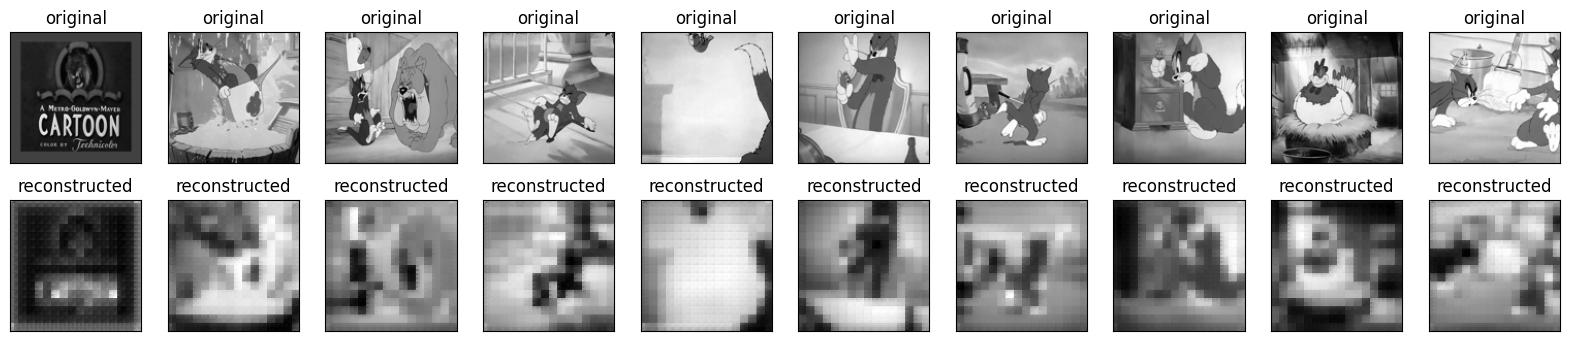

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
